# Deploying the Hybrid Test Bench Emulator Service

In this notebook we will deploy a service that emulates the Hybrid Test Bench PT, and subsequently create a service to store data into the time series database.

To get our service running do the followning:
1. Make sure you're in the root of our repository ([hybrid-test-bench](./))
2. Run the following command: 

```bash
    python -m startup.start_services
   ``` 

This will start both InfluxDB and RabbitMQ services. This way we can have a consistent environment accross all machines.

Local sites, usernames and passwords are the following:

- **InfluxDB:**
  - Local site: [http://localhost:8086/](http://localhost:8086/)
  - User: bench
  - Password: hybridtestbench

- **RabbitMQ:**
  - Local site: [http://localhost:15672/](http://localhost:15672/)
  - User: bench
  - Password: bench

Now you should be able to access these two services, and we'll continue from here.

## Hybrid Test Bench (PT) Emulator Service

The interface of the emulator is very similar to the example for the Incubator ([IncubatorDTCourse\1-Incubator-Service\1-Incubator-Service.ipynb](..\1-Incubator-Service\1-Incubator-Service.ipynb)).

1. We make sure that the **environment** is set up correctly and we configure the **logging**.

2. We create the **pt_emulator_service.py**, which produces RabbitMQ messages that contain data that exactly matches the data produced by the real Hybrid Test Bench. Unlike the real Hybrid Test Bench, we will have to code the behavior that corresponds to applying a force on a specific beam. This behaviour will be triggered by sending a RabbitMQ message that the emulator will listen for. This will result in a change in displacement.

3. We create the **hybrid_test_bench_data_recorder_influx.py**, which deploys a service that subscribes to all relevant messages being exchanged, and stores them in the time series database, so that it can be visualized.

**In the end**, we check that both services are running and we check the data coming to the InfluxDB dashboard. We then send a message, that will affect the behaviour of the emulator and we will be able to see the change in the InfluxDB dashboard.

Run the next two code blocks to set up the environment and configure the logging:

In [1]:
%%writefile logging.conf

[loggers]
keys=root,PTModel,PTEmulatorService,HybridTestBenchDataRecorderInflux

[handlers]
keys=consoleHandler,PTModelFileHandler,PTEmulatorServiceFileHandler,HybridTestBenchDataRecorderInfluxFileHandler

[formatters]
keys=simpleFormatter

[logger_root]
level=DEBUG
handlers=consoleHandler

[logger_PTModel]
level=DEBUG
handlers=PTModelFileHandler
qualname=PTModel
propagate=0

[logger_PTEmulatorService]
level=DEBUG
handlers=PTEmulatorServiceFileHandler
qualname=PTEmulatorService
propagate=0

[logger_HybridTestBenchDataRecorderInflux]
level=DEBUG
handlers=HybridTestBenchDataRecorderInfluxFileHandler
qualname=HybridTestBenchDataRecorderInflux
propagate=0

[handler_consoleHandler]
class=StreamHandler
formatter=simpleFormatter
args=(sys.stdout,)

[handler_PTModelFileHandler]
class=FileHandler
formatter=simpleFormatter
args=('PTModel.log', 'w')

[handler_PTEmulatorServiceFileHandler]
class=FileHandler
formatter=simpleFormatter
args=('PTEmulatorService.log', 'w')

[handler_HybridTestBenchDataRecorderInfluxFileHandler]
class=FileHandler
formatter=simpleFormatter
args=('HybridTestBenchDataRecorderInflux.log', 'w')

[formatter_simpleFormatter]
format=%(asctime)s.%(msecs)03d %(levelname)s %(name)s : %(message)s
datefmt=%Y-%m-%d %H:%M:%S

Overwriting logging.conf


In [2]:
import sys
import os

# Get the current working directory. Should be hybrid-test-bench
current_dir = os.getcwd()

assert os.path.basename(current_dir) == 'hybrid-test-bench', 'Current directory is not hybrid-test-bench'

# Get the parent directory. Should be the root of the repository
parent_dir = current_dir

# The root of the repo should contain the startup folder. Otherwise something went wrong during the inital setup.
assert os.path.exists(os.path.join(parent_dir, 'startup')), 'startup folder not found in the repository root'

# The root of the repo should contain the installation folder. Otherwise something went wrong during the inital setup.
assert os.path.exists(os.path.join(parent_dir, 'installation')), 'installation folder not found in the repository root'

bench_startup_dir = os.path.join(parent_dir, 'startup')

assert os.path.exists(bench_startup_dir), 'hybrid-test-bench startup directory not found'

# Add the parent directory to sys.path
sys.path.append(bench_startup_dir)

Now that we have set up our environment, we continue by creating the PT_emulator_service script:

In [3]:
%%writefile pt_emulator_service.py

# Configure python path to load hybrid test bench modules
import sys
import os
import logging
import logging.config
import time
import numpy as np
from math import *

from scipy.integrate import solve_ivp

# Get the current working directory. Should be hybrid-test-bench
current_dir = os.getcwd()

assert os.path.basename(current_dir) == 'hybrid-test-bench', 'Current directory is not hybrid-test-bench'

# Get the parent directory. Should be the root of the repository
parent_dir = current_dir

from communication.server.rabbitmq import Rabbitmq
from communication.shared.protocol import ROUTING_KEY_STATE, ROUTING_KEY_FORCES
import pt_model as pt_model

# Define the global variables for the model
fx, fy, fz, mx, my, mz = 1, 2, 3, 4, 5, 6 # force and moment indices

# Define the system of ODEs for the bench
def bench_ODE(t, y, s0, omega, v_max, a_max):
    """
    Feedforward-based ODE to follow S(t) = S0 * sin(omega * t),
    matching velocity by adjusting amplitude and clipping to v_max / a_max.
    
    Parameters:
        t (float): Time
        y (array): [x, v] = position and velocity
        S0 (float): Amplitude of target motion
        omega (float): Frequency of motion
        v_max (float): Max allowed velocity
        a_max (float): Max allowed acceleration
        
    Returns:
        dydt: [dx/dt, dv/dt]
    """
    s, v = y

    ts = asin(s/(s0))/omega if abs(s / s0) <= 1 else 0 # time scale for the target motion
    ts = ts if v >= 0 else pi/omega - ts
    
    v0 = s0 * omega
    a0 = v0 * omega

    # Compute target velocity and acceleration
    s_target = s0 * sin(omega * ts)
    v_target = v0 * cos(omega * ts)
    a_target =-a0 * sin(omega * ts)
    
    # Scale amplitude if target velocity exceeds limit
    scale = v_target / v if v != 0 else 1.0
    if a_target == 0 and v_target != v:
        a_target = v_target
        
    a_target = a_target * scale + (v_target - v)

    if abs(s) >= s0:   
        a_target = -(abs(s) - s0) if s > 0 else (abs(s) - s0)

    if s > 0:
        a_max_pos = +a_max
        a_max_neg = -a_max * 2.0
    else:
        a_max_pos = +a_max * 2.0
        a_max_neg = -a_max

    # Clip acceleration to a_max
    v = np.clip(v, -v_max, v_max)
    a = np.clip(a_target, a_max_neg, a_max_pos)

    return [v, a]


class PTEmulatorService:
    
    def __init__(self, uh_initial, uv_initial, lh_initial, lv_initial, execution_interval, rabbitmq_config):
        # Initialize the PTEmulatorService with initial values and configuration
        self._l = logging.getLogger("PTEmulatorService")
        self._l.info("Initializing PTEmulatorService.")

        try:
            self.PT_Model = pt_model.PtModel()
        except Exception as e:
            self._l.error("Failed to initialize PTModel: %s", e, exc_info=True)
            raise

        self._rabbitmq = Rabbitmq(**rabbitmq_config)
        
        self.uh = uh_initial
        self.uv = uv_initial
        self.lh = lh_initial
        self.lv = lv_initial
        self.max_vertical_displacement = 5.0
        self.lh_wanted = 100
        self.uv_wanted = 100
        self.VERTICAL_FREQ = (2*pi/60) / 4
        self.HORIZONTAL_FREQ = (2*pi/60) / 2
        self.VERTICAL_V_Max = self.uv_wanted * self.VERTICAL_FREQ
        self.HORIZONTAL_V_Max = self.lh_wanted * self.HORIZONTAL_FREQ
        self.VERTICAL_A_Max = self.VERTICAL_V_Max * self.VERTICAL_FREQ
        self.HORIZONTAL_A_Max = self.HORIZONTAL_V_Max * self.HORIZONTAL_FREQ
        self._S_bench_v, self._V_bench_v, self._a_bench_v = 0.0, 0.0, 0.0
        self._S_bench_h, self._V_bench_h, self._a_bench_h = 0.0, 0.0, 0.0
        # self.r = r_initial # do we need this for the emulator?
        self._execution_interval = execution_interval # seconds
        self._force_on = 0.0  

    def setup(self):
        self._rabbitmq.connect_to_server()

        # Declare local queues for the force messages
        self.forces_queue_name = self._rabbitmq.declare_local_queue(routing_key=ROUTING_KEY_FORCES)
        #self.load_queue_name = self._rabbitmq.declare_local_queue(routing_key=ROUTING_KEY_LOADS)
        #self.displacement_queue_name = self._rabbitmq.declare_local_queue(routing_key=ROUTING_KEY_DISPLACEMENTS)

        self._l.info(f"PTEmulatorService setup complete.")

    def _read_forces(self):
        # Read the forces from the RabbitMQ queue
        #self._l.debug("Reading forces from RabbitMQ.")
        msg = self._rabbitmq.get_message(self.forces_queue_name)
        #self._l.debug(f"Message received: {msg}")
        if msg is not None:
            return msg
        else:
            return None
    
    def check_control_commands(self):
        # Check if there are control commands
        force_cmd = self._read_forces()
        #self._l.debug(f"Control command: {force_cmd}")
        if force_cmd is not None:
            if 'forces' in force_cmd and force_cmd['forces'] is not None:
                self._l.info("Force command: %s", force_cmd["forces"])
                self._force_on = 1.0 if force_cmd else 0.0

            if "horizontal_force" in force_cmd and force_cmd["horizontal_force"] is not None:
                self._l.info(f"Horizontal force command: {force_cmd['horizontal_force']}")
                self.lh_wanted = force_cmd["horizontal_force"]

            if "vertical_displacement" in force_cmd and force_cmd["vertical_displacement"] is not None:
                self._l.info(f"Vertical force command: {force_cmd['vertical_displacement']}")
                self.uv_wanted = force_cmd["vertical_displacement"]
                
            if "vertical_frequency" in force_cmd and force_cmd["vertical_frequency"] is not None:
                self._l.info(f"Vertical frequency command: {force_cmd['vertical_frequency']}")
                self.set_vertical_frequency(force_cmd["vertical_frequency"])
                
            if "horizontal_frequency" in force_cmd and force_cmd["horizontal_frequency"] is not None:
                self._l.info(f"Horizontal frequency command: {force_cmd['horizontal_frequency']}")
                self.set_horizontal_frequency(force_cmd["horizontal_frequency"])


    def emulate_pt(self):
        # Emulate the PT behavior based on the control commands
        #self._l.info("Emulating.")
        state = [self._force_on, self.lh, self.lv, self.uh, self.uv] # Current state of the PTEmulator
        #self._l.info(f"Current state: {state}")

        # Additional logic for the emulator can go here
        # the if statement is just hardcoded emulator behaviour for now! 
        # _uh, _uv, _lh, _lv, and _r need to be extracted from the simulation results (u, lf, r)
        if self._force_on == 1.0:
            #self._l.info("Force is on, setting displacements and forces from simulation results.")
            # Horizontal displacement

            #Run the ODE solver for the horizontal and vertical motion
            try:
                self.run_ODE()
            except Exception as e:
                self._l.error("ODE solver failed: %s", e, exc_info=True)
                raise

            #self._l.info("Running simulation...")
            try:
                [u, lf, r] = self.PT_Model.run_simulation()
            except Exception as e:
                self._l.error("Simulation failed: %s", e, exc_info=True)
                raise
            #self._l.info(f"Simulation completed. u = {u.shape}, lf = {lf.shape}, r = {r.shape}")

            node10_index = 10
            
            # Horizontal displacement
            try:
                self._uh = float(self.PT_Model.get_displacement(node10_index, fx)[0])
            except IndexError as e:
                self._l.error(f"Error retrieving horizontal displacement from u({node10_index},1): %s", e, exc_info=True)

            # Vertical displacement
            try:
                self._uv = float(self.PT_Model.get_displacement(node10_index, fz)[0])
            except IndexError as e:
                self._l.error(f"Error retrieving vertical displacement from u({node10_index},1): %s", e, exc_info=True)
            
            #Forces
            try:
                # Vertical force
                self._lh = float(self.PT_Model.get_load(node10_index, fx)[0])
                # Horizontal force
                self._lv = float(self.PT_Model.get_load(node10_index, fz)[0])
            except Exception as e:
                self._l.error(f"Error retrieving forces from PT_Model.get_loads(): %s", e, exc_info=True)
                self._l.error(f"Forces not set: lh = {self._lh}, lv = {self._lv}")

            
            #self._l.info(f"Displacements: uh={self._uh}, uv={self._uv}")
            #self._l.info(f"Forces: lh={self._lh}, lv={self._lv}")
            # Restoring force
            
            # self._r = r[something] # in case we need this for the emulator, we can put it here
        else:
            #self._l.info("Force is off, setting displacements and forces to zero.")
            # Horizontal displacement
            self._uh = 0.0
            # Vertical displacement
            self._uv = 0.0
            # Horizontal force
            self._lh = 0.0
            # Vertical force
            self._lv = 0.0
            # Restoring force
            # self._r = r[something] # in case we need this for the emulator, we can put it here

        #self._l.info("PT script executed successfully.")
        
    def send_state(self, time_start):
        #self._l.info("Sending state to hybrid test bench physical twin.")
        timestamp = time.time_ns()
        # Publishes the new state
        message = {
            "measurement": "emulator",
            "time": timestamp,
            "tags": {
                "source": "emulator"
            },
            "fields": {
                "horizontal_displacement": self._uh,
                "vertical_displacement": self._uv,
                "horizontal_force": self._lh,
                "vertical_force": self._lv,
                # "restoring_force": self._r,
                "force_on": self._force_on,
                "max_vertical_displacement": self.max_vertical_displacement,
                "execution_interval": self._execution_interval,
                "elapsed": time.time() - time_start,
            }
        }

        self._rabbitmq.send_message(ROUTING_KEY_STATE, message)
        #self._l.debug(f"Message sent to {ROUTING_KEY_STATE}.")
        #self._l.debug(message)
    
    def start_emulation(self):
        # Start the emulation loop
        self._l.info("Starting PTEmulator emulation loop.")
        try:
            while True:
                #self._l.debug("Emulation loop iteration.")
                time_start = time.time()
                #Check if there are control commands
                self.check_control_commands()
                # Emulate the PT behavior
                self.emulate_pt() 
                # Send the new state to the hybrid test bench physical twin
                self.send_state(time_start)
                # Sleep until the next sample
                time_end = time.time()
                time_diff = time_end - time_start
                if time_diff < self._execution_interval:
                    time.sleep(self._execution_interval - time_diff)
                else:
                    self._l.warning(f"Emulation loop took too long: {time_diff} seconds.")
        except KeyboardInterrupt:
            self._l.info("Emulation loop interrupted by user.")
        except Exception as e:
            self._l.error("Emulation loop failed: %s", e, exc_info=True)

    def run_ODE(self):
        #self._l.info(f"Current state vertical: {state_v}")
        state_h = [self._S_bench_h, self._V_bench_h] # Current state of the PTEmulator
        state_v = [self._S_bench_v, self._V_bench_v] # Current state of the PTEmulator

        try:
            sol_h = solve_ivp(
                lambda t, y: bench_ODE(t, y, self.lh_wanted, self.HORIZONTAL_FREQ, self.HORIZONTAL_V_Max, self.HORIZONTAL_A_Max),
                [0.0, self._execution_interval], state_h, t_eval=np.linspace(0.0, self._execution_interval, 2))
            sol_v = solve_ivp(
                lambda t, y: bench_ODE(t, y, self.uv_wanted, self.VERTICAL_FREQ, self.VERTICAL_V_Max, self.VERTICAL_A_Max),
                [0.0, self._execution_interval], state_v, t_eval=np.linspace(0.0, self._execution_interval, 2))
        except Exception as e:
            self._l.error("ODE solver failed: %s", e, exc_info=True)
            raise

        # Update the state variables
        self._S_bench_h = sol_h.y[0, 1]
        self._V_bench_h = sol_h.y[1, 1]
        self._S_bench_v = sol_v.y[0, 1]
        self._V_bench_v = sol_v.y[1, 1]

        self._l.debug(f"Setting loads and displacements in PTModel. Sv: {np.round(self._S_bench_v,2)}, Sh: {np.round(self._S_bench_h,2)}")
        self._l.debug(f"Setting loads and displacements in PTModel. Vv: {np.round(self._V_bench_v,2)}, Vh: {np.round(self._V_bench_h,2)}")

        try:
            self.PT_Model.set_loads_between_nodes(1, self._S_bench_h, [9,10])
            self.PT_Model.set_displacements_between_nodes(1, self._S_bench_v,[5,10])
        except Exception as e:
            self._l.error("Failed to set load in PTModel: %s", e, exc_info=True)
            raise

    def set_horizontal_frequency(self, frequency):
        # Set the horizontal frequency for the emulator
        #self._l.info(f"Setting horizontal frequency to {frequency}.")
        self.HORIZONTAL_FREQ = (2*pi / 60) / frequency
        self.HORIZONTAL_V_Max = self.lh_wanted * self.HORIZONTAL_FREQ * 1.1
        self.HORIZONTAL_A_Max = self.HORIZONTAL_V_Max * self.HORIZONTAL_FREQ * 1.1
        self._l.info(f"Horizontal frequency set to {self.HORIZONTAL_FREQ}, V_Max: {self.HORIZONTAL_V_Max}, A_Max: {self.HORIZONTAL_A_Max}.")
        
    def set_vertical_frequency(self, frequency):
        # Set the vertical frequency for the emulator
        #self._l.info(f"Setting vertical frequency to {frequency}.")
        self.VERTICAL_FREQ = (2*pi / 60) / frequency
        self.VERTICAL_V_Max = self.uv_wanted * self.VERTICAL_FREQ * 1.1
        self.VERTICAL_A_Max = self.VERTICAL_V_Max * self.VERTICAL_FREQ * 1.1 
        self._l.info(f"Vertical frequency set to {self.VERTICAL_FREQ}, V_Max: {self.VERTICAL_V_Max}, A_Max: {self.VERTICAL_A_Max}.")
    
    
if __name__ == "__main__":
    # Get utility functions to config logging and load configuration
    from pyhocon import ConfigFactory
    
    logging_conf = os.path.join(os.path.dirname(os.getcwd()), 'hybrid-test-bench', 'logging.conf')
    logging.config.fileConfig(logging_conf)

    # Get path to the startup.conf file used in the hybrid test bench PT & DT:
    startup_conf = os.path.join(os.path.dirname(os.getcwd()), 'hybrid-test-bench', 'software','startup.conf')
    assert os.path.exists(startup_conf), 'startup.conf file not found'

    # The startup.conf comes from the hybrid test bench repository.
    config = ConfigFactory.parse_file(startup_conf)
    
    service = PTEmulatorService(
        uh_initial = 0.0,
        uv_initial = 0.0,
        lh_initial = 0.0,
        lv_initial = 0.0,
        # r_initial = 0.0,
        execution_interval = 3.0,
        rabbitmq_config=config["rabbitmq"])

    service.setup()
    
    # Start the PTEmulatorService
    service.start_emulation()

Overwriting pt_emulator_service.py


And we continue by creating the hybrid_test_bench_data_recorder_influx script:

The key parts of this service are:
1. It subscribes to all messages going to a topic that's prefixed by `ROUTING_KEY_RECORDER="hybridtestbench.record.#"`. So a message sent to topic `hybridtestbench.record.driver.state` will also be received by the data recorder. Note that any other service that has declared a local queue attached to that topic will receive a copy of the message.
2. It uses the InfluxDB Client library to write the message data into the time series database. The message is already in the right format.

In [4]:
%%writefile hybrid_test_bench_data_recorder_influx.py


# Configure python path to load incubator modules
import sys
import os
import logging
import logging.config
import time

from influxdb_client import InfluxDBClient
from influxdb_client.client.write_api import SYNCHRONOUS

# Get the current working directory. Should be hybrid-test-bench
current_dir = os.getcwd()

assert os.path.basename(current_dir) == 'hybrid-test-bench', 'Current directory is not hybrid-test-bench'

# Get the parent directory. Should be the root of the repository
parent_dir = current_dir

# The root of the repo should contain the startup folder. Otherwise something went wrong during the inital setup.
assert os.path.exists(os.path.join(parent_dir, 'startup')), 'startup folder not found in the repository root'

# The root of the repo should contain the installation folder. Otherwise something went wrong during the inital setup.
assert os.path.exists(os.path.join(parent_dir, 'installation')), 'installation folder not found in the repository root'

bench_startup_dir = os.path.join(parent_dir, 'startup')

assert os.path.exists(bench_startup_dir), 'hybrid-test-bench startup directory not found'

# Add the parent directory to sys.path
sys.path.append(bench_startup_dir)

from communication.shared.protocol import ROUTING_KEY_RECORDER
from communication.server.rabbitmq import Rabbitmq
import numpy as np

class HybridTestBenchDataRecorderInflux:
    def __init__(self, rabbitmq_config, influxdb_config):
        self._l = logging.getLogger("HybridTestBenchDataRecorderInflux")
        self._l.info("Initializing HybridTestBenchDataRecorderInflux.")
        self._l.info("Connecting to InfluxDB...")    
        client = InfluxDBClient(**influxdb_config)
        write_api = client.write_api(write_options=SYNCHRONOUS)
        self.write_api = write_api
        self.influx_db_org = influxdb_config["org"]
        self.influxdb_bucket = influxdb_config["bucket"]

        self.rabbitmq = Rabbitmq(**rabbitmq_config)

    def read_record_request(self, ch, method, properties, body_json):
        self._l.debug("New record msg:")
        self._l.debug(body_json)
        try:
            self.write_api.write(self.influxdb_bucket, self.influx_db_org, body_json)
        except Exception as e:
            self._l.error("Failed to write to InfluxDB: %s", e, exc_info=True)
            raise

    def setup(self):
        self._l.info("Setting up HybridTestBenchDataRecorderInflux.")
        self.rabbitmq.connect_to_server()

        self.rabbitmq.subscribe(routing_key=ROUTING_KEY_RECORDER,
                           on_message_callback=self.read_record_request)

    def start_recording(self):
        self._l.info("Starting HybridTestBenchDataRecorderInflux.")
        try:
            self.rabbitmq.start_consuming()
        except KeyboardInterrupt:
            self.rabbitmq.close()
    
if __name__ == "__main__":
    # Get utility functions to config logging and load configuration
    from pyhocon import ConfigFactory

    # Get logging configuration
    logging.config.fileConfig("logging.conf")

    # Get path to the startup.conf file used in the hybrid test bench PT & DT:
    startup_conf = os.path.join(os.path.dirname(os.getcwd()), 'hybrid-test-bench', 'software','startup.conf')
    assert os.path.exists(startup_conf), 'startup.conf file not found'

    # The startup.conf comes from the hybrid test bench repository.
    config = ConfigFactory.parse_file(startup_conf)
    
    service = HybridTestBenchDataRecorderInflux(rabbitmq_config=config["rabbitmq"], influxdb_config=config["influxdb"])

    service.setup()
    
    # Start the HybridTestBenchDataRecorderInflux
    service.start_recording()

Overwriting hybrid_test_bench_data_recorder_influx.py


Now we will run both scripts.

First the PT_emulator_service:

In [5]:
# You can run this, or you can run the command below in a new terminal windows to start the service
import subprocess
import time

# Start a process asynchronously
pt_emulator_service_proc = subprocess.Popen([sys.executable, "pt_emulator_service.py"])

# Wait for 5 seconds for the process to start
time.sleep(5)

# Print the PID of the process. You can search for this in your task manager to see the process running and kill it if necessary.
print(f"pt_emulator_service = {pt_emulator_service_proc.pid}")

pt_emulator_service = 768


Then we run the hybrid_test_bench_data_recorder_influx:

In [6]:
# Start a process asynchronously
hybrid_test_bench_data_recorder_influx_proc = subprocess.Popen([sys.executable, "hybrid_test_bench_data_recorder_influx.py"])

# Wait for 5 seconds for the process to start
time.sleep(5)

# Print the PID of the process. You can search for this in your task manager to see the process running and kill it if necessary.
print(f"hybrid_test_bench_data_recorder_influx = {hybrid_test_bench_data_recorder_influx_proc.pid}")

hybrid_test_bench_data_recorder_influx = 26960


Now we check that both services are running:

In [7]:
assert pt_emulator_service_proc.poll() is None, "PTEmulatorService process has crashed"
assert hybrid_test_bench_data_recorder_influx_proc.poll() is None, "HybridTestBenchDataRecorderInflux process has crashed"

We verify that the PT_emulator_service is running by printing the log file:

In [8]:
# Print contents of log file to verify that the service is running
with open('PTEmulatorService.log', 'r') as f:
    print(f.read())

# Check process hasn't crashed
assert pt_emulator_service_proc.poll() is None, "PTEmulatorService process has crashed"

We verify that the hybrid_test_bench_data_recorder_influx is running by printing the log file:

In [9]:
# Print contents of log file to verify that the service is running
with open('HybridTestBenchDataRecorderInflux.log', 'r') as f:
    print(f.read())

2025-04-29 22:21:48.147 INFO HybridTestBenchDataRecorderInflux : Initializing HybridTestBenchDataRecorderInflux.
2025-04-29 22:21:48.147 INFO HybridTestBenchDataRecorderInflux : Connecting to InfluxDB...
2025-04-29 22:21:48.154 INFO HybridTestBenchDataRecorderInflux : Setting up HybridTestBenchDataRecorderInflux.
2025-04-29 22:21:48.242 INFO HybridTestBenchDataRecorderInflux : Starting HybridTestBenchDataRecorderInflux.
2025-04-29 22:21:51.023 DEBUG HybridTestBenchDataRecorderInflux : New record msg:
2025-04-29 22:21:51.023 DEBUG HybridTestBenchDataRecorderInflux : {'measurement': 'emulator', 'time': 1745958110979215400, 'tags': {'source': 'emulator'}, 'fields': {'horizontal_displacement': 0.0, 'vertical_displacement': 0.0, 'horizontal_force': 0.0, 'vertical_force': 0.0, 'force_on': 0.0, 'execution_interval': 3.0, 'elapsed': 0.0026831626892089844}}



On the InfluxDB management page, you should be able to query for the data coming from the emulator:

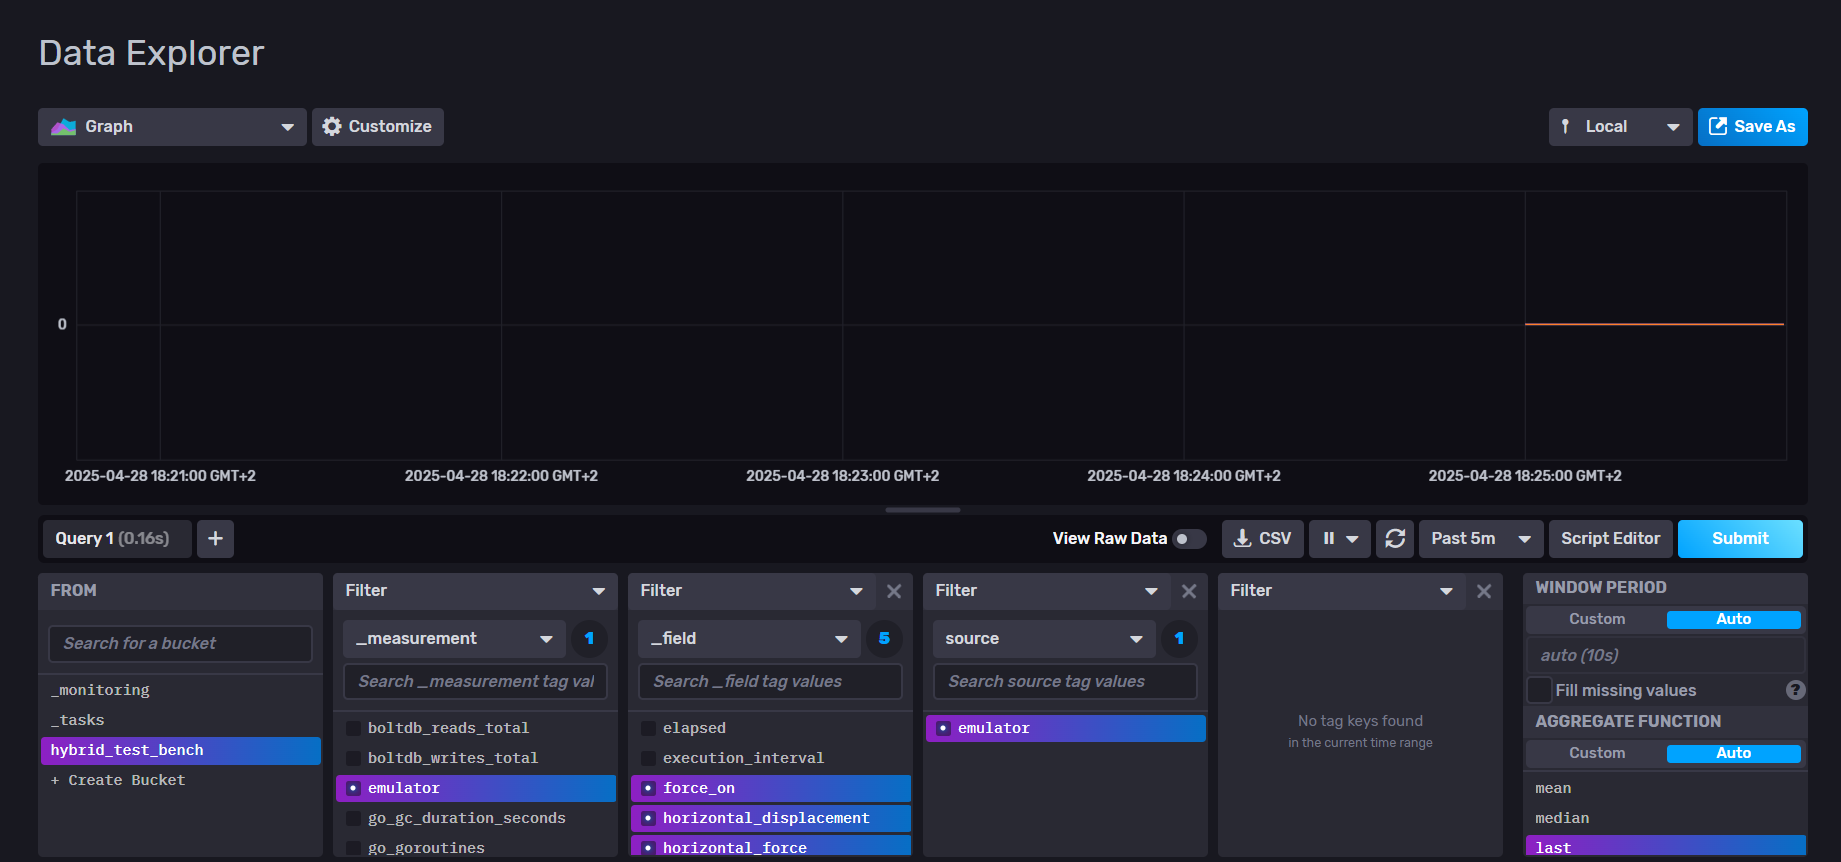

Next, we send the apply force message:

In [10]:
from communication.server.rabbitmq import Rabbitmq
from communication.shared.protocol import ROUTING_KEY_FORCES

from pyhocon import ConfigFactory

# Get config
startup_conf = os.path.join(os.path.dirname(os.getcwd()), 'hybrid-test-bench', 'software','startup.conf')
config = ConfigFactory.parse_file(startup_conf)

# Send a message to the PT to simulate the application of a force
with Rabbitmq(**config["rabbitmq"]) as rabbitmq:
    rabbitmq.send_message(ROUTING_KEY_FORCES, {"forces": True})

# Wait a bit for the message to be processed
time.sleep(5)

Now we edit the displacement/force

In [11]:
from communication.server.rabbitmq import Rabbitmq
from communication.shared.protocol import ROUTING_KEY_FORCES

from pyhocon import ConfigFactory

# Get config
startup_conf = os.path.join(os.path.dirname(os.getcwd()), 'hybrid-test-bench', 'software','startup.conf')
config = ConfigFactory.parse_file(startup_conf)

# Send a message to the PT to simulate the application of a force
with Rabbitmq(**config["rabbitmq"]) as rabbitmq:
    rabbitmq.send_message(ROUTING_KEY_FORCES, {"forces": True,
                                               "horizontal_force": 500, 
                                               "vertical_displacement": 250,
                                               "horizontal_frequency": 4.0,
                                               "vertical_frequency": 2.0})

# Wait a bit for the message to be processed
time.sleep(5)

We can see the change in the dashboard:

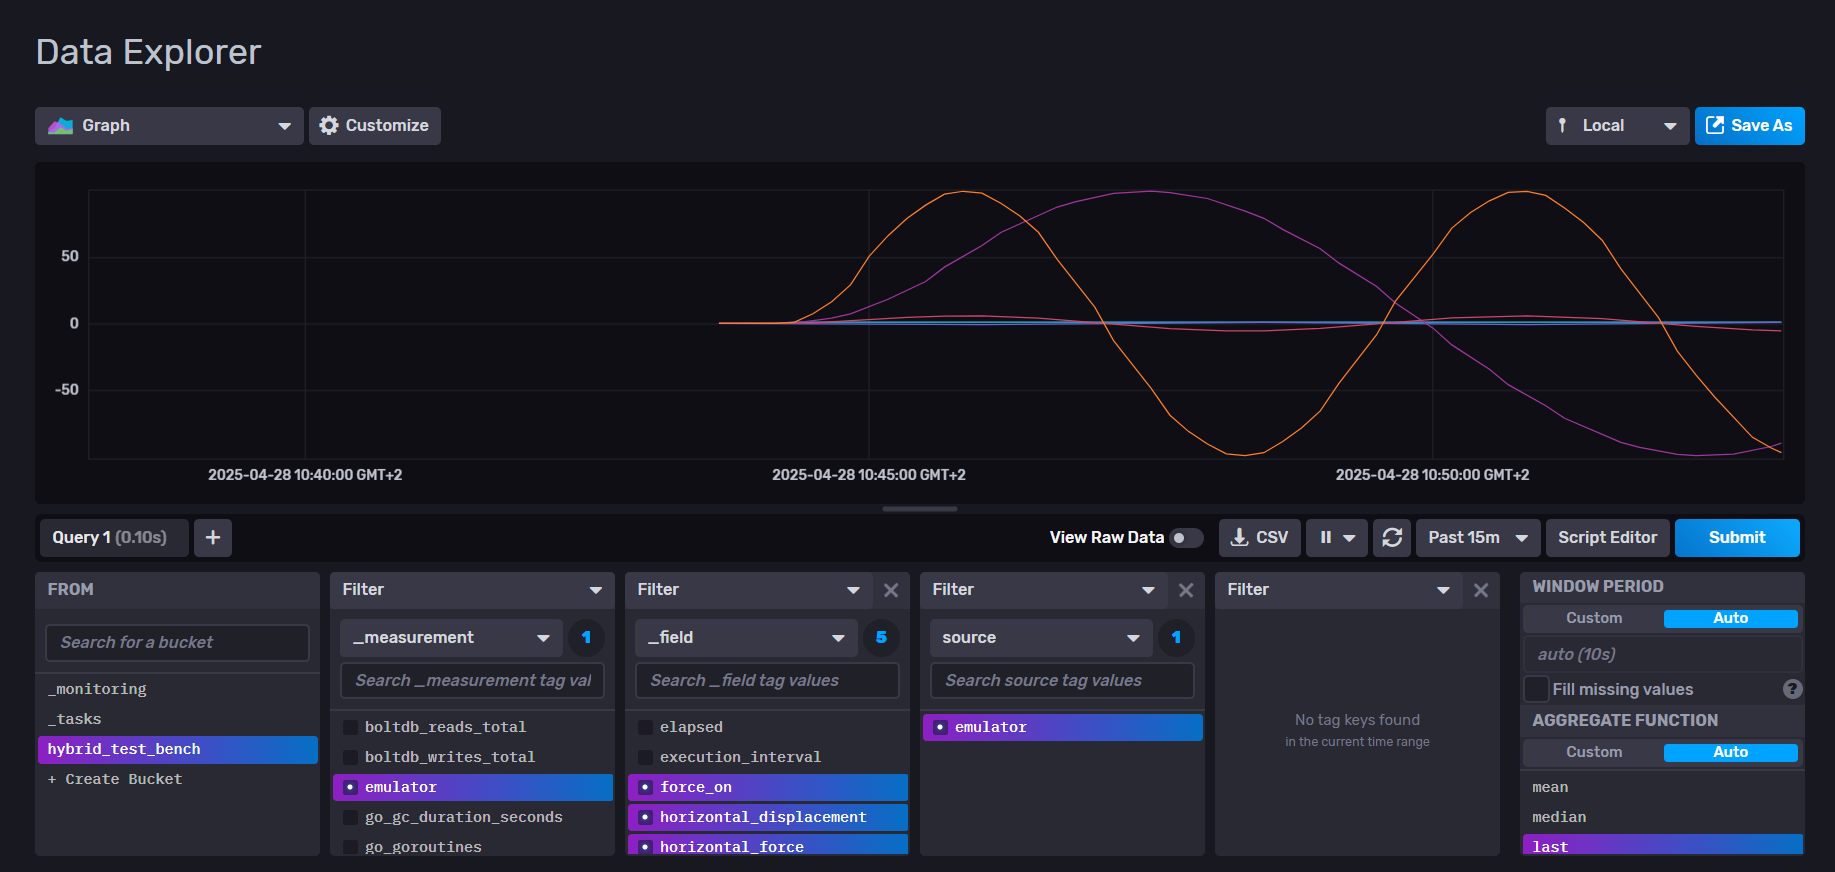

Here we can turn off the force:

In [ ]:
# Get config
startup_conf = os.path.join(os.path.dirname(os.getcwd()), 'hybrid-test-bench', 'software','startup.conf')
config = ConfigFactory.parse_file(startup_conf)

# Send a message to the PT to simulate the application of a force
with Rabbitmq(**config["rabbitmq"]) as rabbitmq:
    rabbitmq.send_message(ROUTING_KEY_FORCES, {"forces": False})

# Wait a bit for the message to be processed
time.sleep(5)

In this last step we kill both processes:

In [17]:
pt_emulator_service_proc.terminate() # Terminate the process. Send SIGTERM signal to the process. The process can catch this signal and perform cleanup operations before exiting, so we wait.
pt_emulator_service_proc.wait()  # Wait for the process to exit fully. Should print exit code 1, due to interruption.

# Ensure process has exited
assert pt_emulator_service_proc.returncode is not None, 'Process has not exited'

In [18]:
hybrid_test_bench_data_recorder_influx_proc.terminate() # Terminate the process. Send SIGTERM signal to the process. The process can catch this signal and perform cleanup operations before exiting, so we wait.
hybrid_test_bench_data_recorder_influx_proc.wait()  # Wait for the process to exit fully. Should print exit code 1, due to interruption.

# Ensure process has exited
assert hybrid_test_bench_data_recorder_influx_proc.returncode is not None, 'Process has not exited'